In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence
import sys
sys.path.append('..')

In [37]:
import pandas as pd
from data.tempdata import TempData
import matplotlib.pyplot as plt
# Load the data
data_path = '../data/data_with_desc.csv'
data = pd.read_csv(data_path, header=None)
data_test = TempData(data=data, max_num_context=10)

batch, knowledge = data_test.generate_batch(batch_size=8, return_knowledge=True)

print(knowledge)
for i in range(8):
    x_target = batch.x_target[i].flatten()
    y_target = batch.y_target[i].flatten()
    plt.plot(x_target.numpy(), y_target.numpy())
for i in range(8):
    x_context = batch.x_context[i].flatten()
    y_context = batch.y_context[i].flatten()
    plt.scatter(x_context.numpy(), y_context.numpy())
plt.show()

(107,)


IndexError: index 333 is out of bounds for axis 0 with size 107

In [11]:
print(sine_data_test.y_values)

tensor([[ -5.9000,  -5.6000,  -5.2000,  ...,  -8.1000,  -7.9000,  -8.0000],
        [ -8.4000,  -8.5000,  -8.8000,  ..., -16.3000, -16.3000, -16.3000],
        [-16.4000, -16.4000, -16.4000,  ..., -18.3000, -18.3000, -18.2000],
        ...,
        [  8.3000,   9.4000,   9.4000,  ...,   5.4000,   5.6000,   5.1000],
        [  5.2000,   4.7000,   3.9000,  ...,  11.1000,  11.1000,  11.2000],
        [ 11.3000,  11.3000,  11.3000,  ...,  10.4000,  10.4000,  10.3000]])


In [17]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader
import numpy as np

class TemperatureDataset(Dataset):

    def __init__(self, data: pd.DataFrame, max_num_context: int = 10):
        self.data = data
        self.max_num_context = max_num_context

        x_values = data.iloc[0][1:].values.astype('float32')
        self.x_values = torch.from_numpy(x_values) # Shape: [1, num_points]
        self.y_values_train = torch.tensor(data.iloc[1:508, 1:].values).float()  # Shape: [num_samples, num_points]
        self.y_values_val = torch.tensor(data.iloc[619:, 1:].values).float()  # Shape: [num_samples, num_points]
    
    def __len__(self):
        return len(self.y_values_train)
    
    def __getitem__(self, idx):
        y_values = self.y_values_train[idx]
        num_total_points = self.x_values.size(-1)
        num_context = np.random.randint(low=1, high=self.max_num_context)

        context_indices = np.random.choice(num_total_points, num_context, replace=False)

        x_context = self.x_values[context_indices]
        y_context = y_values[context_indices]

        x_target = self.x_values
        y_target = y_values

        return x_context, y_context, x_target, y_target
    


NeuralProcess(
  (latent_encoder): LatentEncoder(
    (phi): BatchMLP(
      (mlp): Sequential(
        (0): Linear(in_features=2, out_features=50, bias=True)
        (1): ReLU()
        (2): Linear(in_features=50, out_features=50, bias=True)
        (3): ReLU()
        (4): Linear(in_features=50, out_features=50, bias=True)
        (5): Identity()
      )
    )
    (rho): BatchMLP(
      (mlp): Sequential(
        (0): Linear(in_features=50, out_features=50, bias=True)
        (1): ReLU()
        (2): Linear(in_features=50, out_features=100, bias=True)
        (3): Identity()
      )
    )
  )
  (decoder): Decoder(
    (target_transform): Linear(in_features=1, out_features=50, bias=True)
    (decoder): BatchMLP(
      (mlp): Sequential(
        (0): Linear(in_features=100, out_features=50, bias=True)
        (1): ReLU()
        (2): Linear(in_features=50, out_features=50, bias=True)
        (3): ReLU()
        (4): Linear(in_features=50, out_features=50, bias=True)
        (5): ReLU()

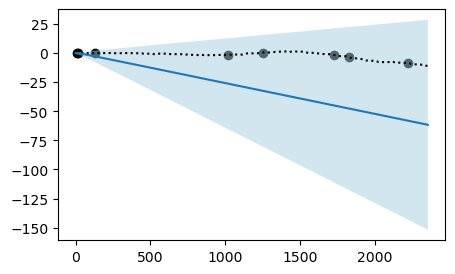

iter 1001: Avg. Loss = 4.3332951128482815
iter 2001: Avg. Loss = 3.359364269733429
iter 3001: Avg. Loss = 2.3750114866495133
iter 4001: Avg. Loss = 2.3426650539636613
iter 5001: Avg. Loss = 2.2896352249383924
iter 6001: Avg. Loss = 2.260762399196625
iter 7001: Avg. Loss = 2.220473192214966
iter 8001: Avg. Loss = 2.2129973767995836
iter 9001: Avg. Loss = 2.1985847556591036
iter 10001: Avg. Loss = 2.180501536130905
iter 10001: Avg. Loss SLOW = 25.77329040813446
iter 11001: Avg. Loss = 2.1626337658166888
iter 12001: Avg. Loss = 2.135077731490135
iter 13001: Avg. Loss = 2.1471461012363435
iter 14001: Avg. Loss = 2.116163459897041
iter 15001: Avg. Loss = 2.103930498242378
iter 16001: Avg. Loss = 2.0450945874452593
iter 17001: Avg. Loss = 2.0042906811237335
iter 18001: Avg. Loss = 1.9670346611738205
iter 19001: Avg. Loss = 1.94877299118042
iter 20001: Avg. Loss = 1.9179430289268493
iter 20001: Avg. Loss SLOW = 20.54808750653267


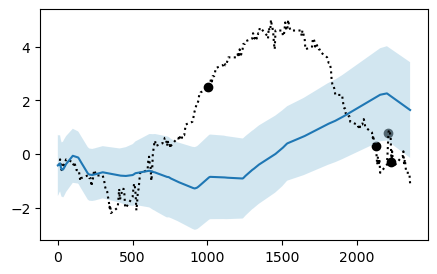

iter 21001: Avg. Loss = 1.8927544133663177
iter 22001: Avg. Loss = 1.893519255399704
iter 23001: Avg. Loss = 1.8675745327472686
iter 24001: Avg. Loss = 1.8578996040821076
iter 25001: Avg. Loss = 1.8503813893795014
iter 26001: Avg. Loss = 1.860043133854866
iter 27001: Avg. Loss = 1.8501162618398665
iter 28001: Avg. Loss = 1.8388234877586365
iter 29001: Avg. Loss = 1.8296135394573212
iter 30001: Avg. Loss = 1.8255585104227066
iter 30001: Avg. Loss SLOW = 18.566284128308297
iter 31001: Avg. Loss = 1.8099034789800643
iter 32001: Avg. Loss = 1.801193601489067
iter 33001: Avg. Loss = 1.811046000123024
iter 34001: Avg. Loss = 1.7884359282255173
iter 35001: Avg. Loss = 1.7991903450489044
iter 36001: Avg. Loss = 1.7887035340070725
iter 37001: Avg. Loss = 1.7756030025482177
iter 38001: Avg. Loss = 1.7657427188158035
iter 39001: Avg. Loss = 1.7759169179201126
iter 40001: Avg. Loss = 1.7593564912080766
iter 40001: Avg. Loss SLOW = 17.87509201836586


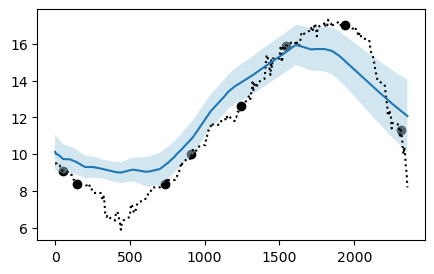

iter 41001: Avg. Loss = 1.7602807041406632
iter 42001: Avg. Loss = 1.7390628488063813
iter 43001: Avg. Loss = 1.7436126264333724
iter 44001: Avg. Loss = 1.7398350338935853
iter 45001: Avg. Loss = 1.7444876972436905
iter 46001: Avg. Loss = 1.732101233482361
iter 47001: Avg. Loss = 1.7141436017751694
iter 48001: Avg. Loss = 1.716569495677948
iter 49001: Avg. Loss = 1.7252181998491287
iter 50001: Avg. Loss = 1.6961033717393874
iter 50001: Avg. Loss SLOW = 17.311414813041687
iter 51001: Avg. Loss = 1.6920535978078841
iter 52001: Avg. Loss = 1.6937657672166824
iter 53001: Avg. Loss = 1.6929548074007035
iter 54001: Avg. Loss = 1.6955930275917053
iter 55001: Avg. Loss = 1.6802685223817826
iter 56001: Avg. Loss = 1.6814861711263656
iter 57001: Avg. Loss = 1.6632028543949127
iter 58001: Avg. Loss = 1.664903583407402
iter 59001: Avg. Loss = 1.6529622305631637
iter 60001: Avg. Loss = 1.6550234266519546
iter 60001: Avg. Loss SLOW = 16.772213988542557


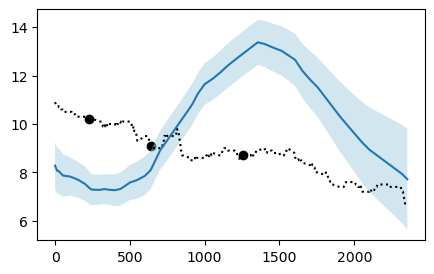

iter 61001: Avg. Loss = 1.6516319717168808
iter 62001: Avg. Loss = 1.6495420472621918
iter 63001: Avg. Loss = 1.6374511978626252
iter 64001: Avg. Loss = 1.6439028035402299
iter 65001: Avg. Loss = 1.6466343380212785
iter 66001: Avg. Loss = 1.6322771222591401
iter 67001: Avg. Loss = 1.639431208372116
iter 68001: Avg. Loss = 1.6478574659824372
iter 69001: Avg. Loss = 1.6335358580350876
iter 70001: Avg. Loss = 1.6273273676633835
iter 70001: Avg. Loss SLOW = 16.40959138071537
iter 71001: Avg. Loss = 1.6206550823450088
iter 72001: Avg. Loss = 1.6313375111818313
iter 73001: Avg. Loss = 1.6225043774843215
iter 74001: Avg. Loss = 1.6052641242742538
iter 75001: Avg. Loss = 1.6065872895717621
iter 76001: Avg. Loss = 1.603659572005272
iter 77001: Avg. Loss = 1.611524032831192
iter 78001: Avg. Loss = 1.6162341272830962
iter 79001: Avg. Loss = 1.5966298828125
iter 80001: Avg. Loss = 1.6002088454961776
iter 80001: Avg. Loss SLOW = 16.114604845285417


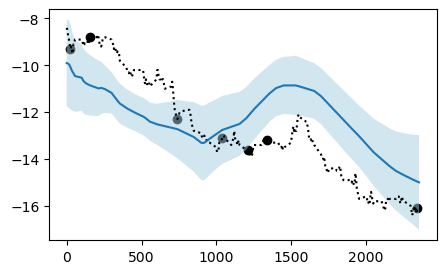

iter 81001: Avg. Loss = 1.59129408121109
iter 82001: Avg. Loss = 1.5964238119125367
iter 83001: Avg. Loss = 1.5905376987457276
iter 84001: Avg. Loss = 1.5811324812173844
iter 85001: Avg. Loss = 1.5786067099571228
iter 86001: Avg. Loss = 1.5851595846414566
iter 87001: Avg. Loss = 1.582240068078041


KeyboardInterrupt: 

In [32]:
from src.plot import plot_predictive
from src.np import NeuralProcess

x_dim = 1
y_dim = 1
determ_dim = 50  # Dimension of representation of context points
latent_dim = 50  # Dimension of sampled latent variable
hidden_dim = 50  # Dimension of hidden layers in encoder and decoder
np = NeuralProcess(x_dim=x_dim,
                   y_dim=y_dim,
                   hidden_dim=hidden_dim,
                   latent_dim=latent_dim,
                   determ_dim=determ_dim,
                   n_h_layers_decoder=3,
                   n_h_layers_phi_latent_encoder=2,
                   n_h_layers_rho_latent_encoder=1,
                   n_h_layers_phi_determ_encoder=6,
                   n_h_layers_rho_determ_encoder=0,
                   use_deterministic_path=False)
print(np)
print(sum(p.numel() for p in np.parameters() if p.requires_grad))

#data = SineData(max_num_context=30, random_kernel_parameters=True)
optimiser = torch.optim.Adam(np.parameters(), lr=3e-4)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")
np.to(device)


data_path = '../data/data.csv'
data = pd.read_csv(data_path, header=None)
data = TempData(data=data , max_num_context=10)
train_loss = []
avg_loss_fast = 0
avg_loss_slow = 0
for iter in range(100000+1):
    np.training = True
    optimiser.zero_grad()

    batch = data.generate_batch(batch_size=16, device=device)
    p_y_pred, loss = np(batch.x_context, batch.y_context, batch.x_target, None, batch.y_target)

    loss.backward()
    optimiser.step()
    train_loss.append(loss.item())

    avg_loss_slow += loss.item()
    avg_loss_fast += loss.item()
    
    if iter % 1000 == 0 and iter > 0:
        print(f"iter {iter+1}: Avg. Loss = {avg_loss_fast/1000}")
        #print(f"iter. loss = {loss.item()}, iter. Loss2 (not being backpropped on) = {loss2.item()}")
        avg_loss_fast = 0 
    if iter % 10000 == 0 and iter > 0:
        print(f"iter {iter+1}: Avg. Loss SLOW = {avg_loss_slow/1000}")
        avg_loss_slow = 0 
    if iter % 20000 == 0:
        np.training = False
        batch = data.generate_batch(batch_size=1, device=np.device)
        plot_predictive(np, batch, knowledge=None, save=False, iter=None)
        np.training = True

plt.plot(train_loss, label='train_loss')
window = 50
plt.plot([sum(train_loss[i:i+window])/window for i in range(len(train_loss)-window)], label=f'train_loss_{window}_smooth')
plt.legend()
plt.show()